In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

# Ice Cream Production Data

In [47]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')


In [64]:
# parse_dates =[0]: Make the 0th column of my data as date and set it as index
production_ice_cream = pd.read_csv('ice_cream.csv', parse_dates=[0], index_col=0, date_parser=parser).squeeze()

In [65]:
production_ice_cream.rename('production', inplace=True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [66]:
#infer the frequency of the data , set the data as monthly so that we can plot and analyse with clarity
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

In [67]:
#filter the data from 2010 onwards
start_date = pd.to_datetime('2010-01-01')
production_ice_cream = production_ice_cream[start_date:]
production_ice_cream.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 121 entries, 2010-01-01 to 2020-01-01
Freq: MS
Series name: production
Non-Null Count  Dtype  
--------------  -----  
121 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


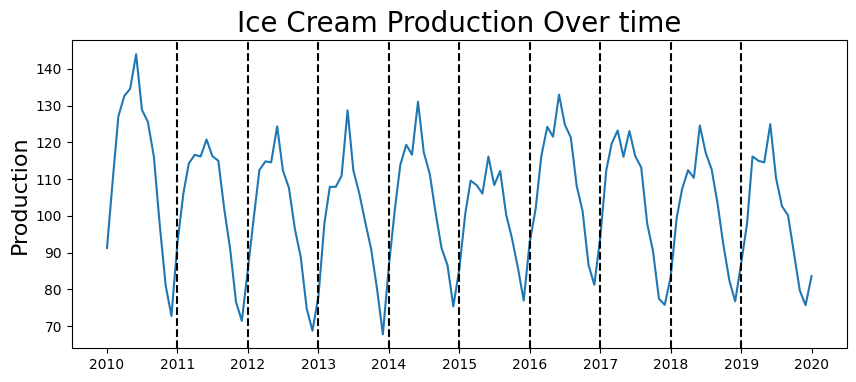

In [56]:
plt.figure(figsize=(10,4))
plt.plot(production_ice_cream)
plt.title('Ice Cream Production Over time', fontsize = 20)
plt.ylabel('Production', fontsize=16)
for year in range(2011, 2020):
    plt.axvline(pd.to_datetime(str(year)+ '-01-01'), color = 'k', linestyle='--')

# ACF

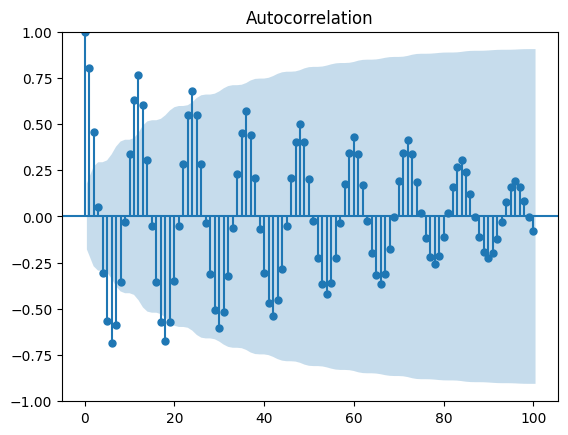

In [68]:
acf_plot = plot_acf(production_ice_cream, lags = 100)

# PACF

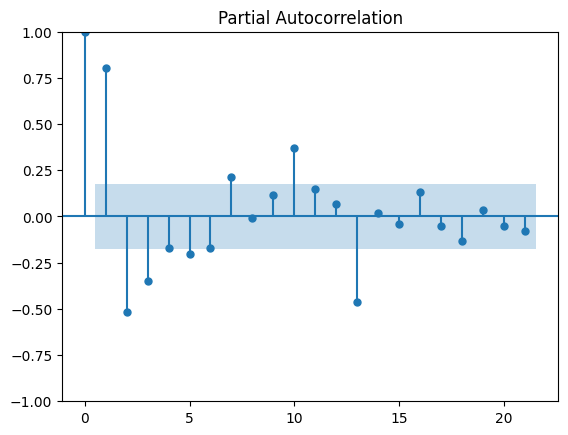

In [69]:
pacf_plot = plot_pacf(production_ice_cream)

# AR Model

Now what kind of AR model can we try to fit in here? /
For that we need to look at the PACF and see which lags are imp \
Here till lag 3 it's fine to start with and then we can go further till lag 7 or so and see the difference in the evaluation metrics to see which lags are really imp and have an impact in the prediction

## Get Training and testing sets

In [77]:
train_end = datetime(2018,12,1)
test_end = datetime(2020,12,31)

# 2010-2018
train_data = production_ice_cream[:train_end]
# time delta basically allows us to shift the amount of time we want
# test = 2019-2020
test_data = production_ice_cream[train_end + timedelta(days=1): test_end]

# Fit the AR Model

In [78]:
# we want to make it an AR3 model so in order AR order is 3 and MA order is 0
ar3_model = ARIMA(train_data, order=(3,0,0))

In [79]:
# fit the model
start = time()
model_fit = ar3_model.fit()
end = time()

print('Model Fitting Time:', end-start)

Model Fitting Time: 0.05788707733154297


In [80]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -374.085
Date:                Sun, 16 Jul 2023   AIC                            758.170
Time:                        09:34:10   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5743      2.169     47.761      0.000      99.324     107.825
ar.L1          1.0469      0.102     10.256      0.000       0.847       1.247
ar.L2         -0.0523      0.175     -0.298      0.7

Here in the above summary the table 2 containing lag information is very important. /
So basically the ones having p-value < 0.05 are significant so ar.L2 i.e l2 lag is not that signicant for our prediction.So when I am trying to build the model I will take lag1 and lag3

In [81]:
# get the prediction from the test data from start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [82]:
predictions = model_fit.predict(start = pred_start_date, end = pred_end_date)
residuals =test_data - predictions

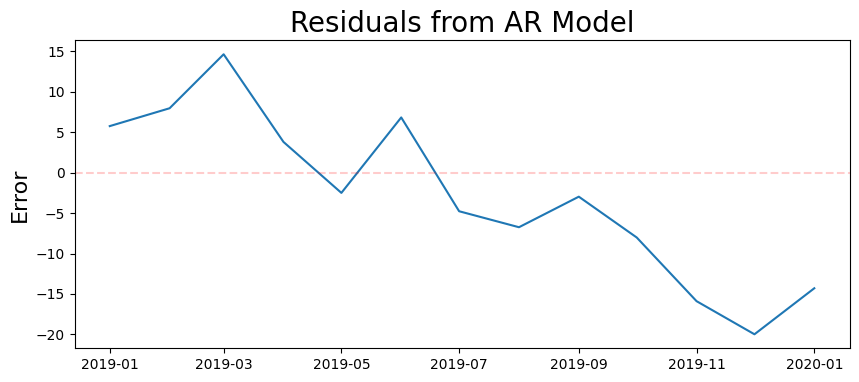

In [84]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Here we can see the models has some patterns in the residuals which still needs to be learned. So AR(3) model is not that good as of now,